In [1]:
# load libs and modules
import numpy as np
import pandas as pd
import get_data
import preprocess_data
import pickle5

# import sklearn models and functions
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
import xgboost as xgb

# for queries
from sqlalchemy import create_engine
from MyCreds.mycreds import Capstone_AWS_RO       #from local site-packages

In [20]:

engine = create_engine(f'postgresql+psycopg2://{Capstone_AWS_RO.username}:{Capstone_AWS_RO.password}@{Capstone_AWS_RO.host}/Capstone', echo=False)
sql_alc_cnxn = engine.connect()

query1='''select 
        date_part('year',month::date) as transaction_year,
        AVG(resale_price_norm.price_per_sq_m_per_lease_yr_norm) as avg,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY price_per_sq_m_per_lease_yr_norm) AS median,
        STDDEV(price_per_sq_m_per_lease_yr_norm) AS standard_deviation
from resale_price_norm
group by transaction_year'''

query2='''
select 
        date_part('year',month::date) as transaction_year,
        transaction_id,
        resale_price_norm.price_per_sq_m_per_lease_yr_norm as norm_price_per_sqm_per_lease_yr
from resale_price_norm

'''

average_df = pd.read_sql(query1, sql_alc_cnxn)
trans_df = pd.read_sql(query2, sql_alc_cnxn)

In [36]:
average_df['+1SD'] = average_df['avg']+average_df['standard_deviation']
average_df['-1SD'] = average_df['avg']-average_df['standard_deviation']
average_df['+2SD'] = average_df['avg']+average_df['standard_deviation']+average_df['standard_deviation']
average_df['-2SD'] = average_df['avg']-average_df['standard_deviation']-average_df['standard_deviation']
average_df['variance'] = average_df['standard_deviation']*average_df['standard_deviation']

In [5]:
trans_df

,transaction_year,transaction_id,norm_price_per_sqm_per_lease_yr
0,2004.0,2004_06_545_WOODLANDS_DR_16_07_TO_09,48.211007
1,2004.0,2004_06_545_WOODLANDS_DR_16_01_TO_03,47.306919
2,2004.0,2004_06_544_WOODLANDS_DR_16_04_TO_06,52.563243
3,2004.0,2004_06_543_WOODLANDS_DR_16_07_TO_09,39.552540
4,2004.0,2004_06_204_MARSILING_DR_13_TO_15,57.314961
...,...,...,...
867672,2004.0,2004_06_7_MARSILING_DR_10_TO_12,47.484405
867673,2004.0,2004_06_8_MARSILING_DR_07_TO_09,50.821147
867674,2004.0,2004_06_721_WOODLANDS_CIRCLE_10_TO_12,49.611728
867675,2004.0,2004_06_701_WOODLANDS_DR_40_01_TO_03,42.931321


<AxesSubplot:xlabel='transaction_year', ylabel='norm_price_per_sqm_per_lease_yr'>

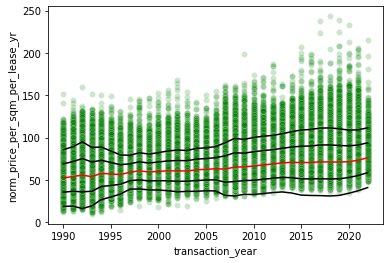

In [42]:
import seaborn as sns

sns.scatterplot(data=trans_df, x="transaction_year", y="norm_price_per_sqm_per_lease_yr",color='green',alpha=0.2)
sns.lineplot(data=average_df,x='transaction_year',y='avg',color='red')
sns.lineplot(data=average_df,x='transaction_year',y='+1SD',color='black')
sns.lineplot(data=average_df,x='transaction_year',y='-1SD',color='black')
sns.lineplot(data=average_df,x='transaction_year',y='+2SD',color='black')
sns.lineplot(data=average_df,x='transaction_year',y='-2SD',color='black')



<AxesSubplot:xlabel='transaction_year', ylabel='variance'>

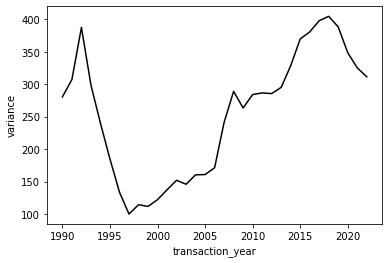

In [34]:
sns.lineplot(data=average_df,x='transaction_year',y='variance',color='black')